## Try phase association for stations on 10/14/2012
Refernce: https://github.com/yetinam/pyocto

In [1]:
# !pip3 install numpy
# !pip3 install pyrocko

In [2]:
import pyocto
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from scipy import signal
from obspy.signal.trigger import classic_sta_lta

from obspy.clients.fdsn import Client
from obspy.core.utcdatetime import UTCDateTime
from pnwstore.mseed import WaveformClient


In [3]:
# Import the velocity model from https://colab.research.google.com/github/yetinam/pyocto/blob/main/examples/02_velocity_models.ipynb#scrollTo=1c52ed9e-d9c1-4fa6-a549-de702bc9d439
# !wget https://github.com/yetinam/pyocto/raw/main/tests/data/graeber.csv

## Input Data

In [5]:
picks = pd.read_csv("~/notebooks/src/workflow/data/picks_20121014.csv",index_col=0)
stations = pd.read_csv("~/notebooks/src/workflow/data/stations_20121014.csv",index_col=0)

In [6]:
picks

station                         time phase
0      FS09B  2012-10-14T00:05:57.814700Z     P
1      FS09B  2012-10-14T00:26:31.574700Z     P
2      FS09B  2012-10-14T00:37:17.174700Z     P
3      FS09B  2012-10-14T00:39:52.134700Z     P
4      FS09B  2012-10-14T00:47:23.734700Z     P
...      ...                          ...   ...
2067    M14B  2012-10-14T22:24:36.789869Z     S
2068    M14B  2012-10-14T22:26:19.909869Z     S
2069    M14B  2012-10-14T23:29:58.769869Z     S
2070    M14B  2012-10-14T23:32:10.929869Z     S
2071    M14B  2012-10-14T23:38:56.349869Z     S

[2072 rows x 3 columns]

In [7]:
stations

id   longitude   latitude  elevation
0  FS09B -124.808502  40.438702    -2161.0
1   G10B -125.553299  40.677898    -2936.0
2   G19B -125.773598  41.307400    -3071.0
3   G25B -124.586098  41.919899     -430.0
4   G27B -126.016701  41.916599    -3480.0
5   J09B -124.726997  43.151001     -252.0
6   M12B -124.946098  42.183998    -1045.0
7   M14B -124.589699  40.985001     -638.0

  ## Velocoty Models

In [8]:
velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
)

In [9]:
?pyocto.OctoAssociator.from_area

## Create a 1D velocity model

In [10]:
# layers = pd.read_csv("graeber.csv")
# layers

In [11]:
# model_path = "velocity_model"
# pyocto.VelocityModel1D.create_model(layers, 1., 400, 250, model_path)

In [12]:
# velocity_model_1d = pyocto.VelocityModel1D(model_path, tolerance=2.0)

## The OctoAssociator class

In [13]:
associator = pyocto.OctoAssociator.from_area(
    lat=(40, 43.5),
    lon=(-126.5, -123),
    zlim=(0, 50),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=4,
    n_p_picks=3,
    n_s_picks=1,
    n_p_and_s_picks=1,
)

In [14]:
associator.crs

<Projected CRS: +proj=tmerc +lat_0=41.75 +lon_0=-124.75 +units=km  ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (kilometre)
- N[north]: Northing (kilometre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
associator.transform_stations(stations)
stations

id   longitude   latitude  elevation           x           y      z
0  FS09B -124.808502  40.438702    -2161.0   -4.963595 -145.625525  2.161
1   G10B -125.553299  40.677898    -2936.0  -67.913996 -118.755232  2.936
2   G19B -125.773598  41.307400    -3071.0  -85.719842  -48.651523  3.071
3   G25B -124.586098  41.919899     -430.0   13.596424   18.883688  0.430
4   G27B -126.016701  41.916599    -3480.0 -105.085006   19.280241  3.480
5   J09B -124.726997  43.151001     -252.0    1.871087  155.626312  0.252
6   M12B -124.946098  42.183998    -1045.0  -16.199984   48.223921  1.045
7   M14B -124.589699  40.985001     -638.0   13.490014  -84.949193  0.638

## Convert the timestamps to floats

In [16]:
picks["time"] = picks["time"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ'))

In [17]:
picks["time"] = picks["time"].apply(lambda x: x.timestamp())
picks

station          time phase
0      FS09B  1.350173e+09     P
1      FS09B  1.350174e+09     P
2      FS09B  1.350175e+09     P
3      FS09B  1.350175e+09     P
4      FS09B  1.350176e+09     P
...      ...           ...   ...
2067    M14B  1.350253e+09     S
2068    M14B  1.350254e+09     S
2069    M14B  1.350257e+09     S
2070    M14B  1.350258e+09     S
2071    M14B  1.350258e+09     S

[2072 rows x 3 columns]

In [18]:
type(1.349050e+09)

float

## Delete unnecessary columns

In [19]:
# picks.drop(columns="Unnamed: 0", inplace=True)
# picks

In [20]:
# stations.drop(columns="Unnamed: 0", inplace=True)
# stations

## Apply  the associator

In [21]:
events, assignments = associator.associate(picks, stations)

In [22]:
events

idx          time          x           y          z  picks
0    0  1.350178e+09 -99.823478    8.014299  24.609375      4
1    1  1.350182e+09  26.269336 -128.412984  40.234375      5
2    2  1.350184e+09  12.259024 -107.072404  49.609375      7
3    3  1.350197e+09 -18.096654  -97.926441  19.140625      4
4    4  1.350201e+09 -89.315744 -138.321111  36.328125     14
5    5  1.350216e+09 -18.096654   27.830552   1.171875      4
6    6  1.350226e+09 -75.305431 -127.650821  28.515625      4
7    7  1.350234e+09 -60.127592 -121.553512  37.890625     14
8    8  1.350239e+09  61.295118 -104.785913   8.984375      4
9    9  1.350244e+09   6.421393  -62.104752   1.171875      4

In [23]:
Counter(events['picks'])

Counter({4: 6, 14: 2, 5: 1, 7: 1})

In [24]:
associator.transform_events(events)
events["time"] = events["time"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)
events

idx                             time          x           y          z  \
0    0 2012-10-14 01:24:03.676530+00:00 -99.823478    8.014299  24.609375   
1    1 2012-10-14 02:39:44.924554+00:00  26.269336 -128.412984  40.234375   
2    2 2012-10-14 03:08:04.522444+00:00  12.259024 -107.072404  49.609375   
3    3 2012-10-14 06:39:14.450545+00:00 -18.096654  -97.926441  19.140625   
4    4 2012-10-14 07:45:27.532755+00:00 -89.315744 -138.321111  36.328125   
5    5 2012-10-14 12:02:37.496525+00:00 -18.096654   27.830552   1.171875   
6    6 2012-10-14 14:38:21.428889+00:00 -75.305431 -127.650821  28.515625   
7    7 2012-10-14 16:53:05.638758+00:00 -60.127592 -121.553512  37.890625   
8    8 2012-10-14 18:16:43.973209+00:00  61.295118 -104.785913   8.984375   
9    9 2012-10-14 19:52:13.871130+00:00   6.421393  -62.104752   1.171875   

   picks   latitude   longitude      depth  
0      4  41.815873 -125.951392  24.609375  
1      5  40.593306 -124.439672  40.234375  
2      7  40.785806 -124.604763  49.609375  
3      4  40.868056 -124.964663  19.140625  
4     14  40.499693 -125.803638  36.328125  
5      4  42.000358 -124.968426   1.171875  
6      4  40.597160 -125.639653  28.515625  
7     14  40.653305 -125.460940  37.890625  
8      4  40.804200 -124.023617   8.984375  
9      4  41.190790 -124.673457   1.171875

In [25]:
# events.to_csv('~/notebooks/src/association_events.csv')

In [26]:
assignments

event_idx  pick_idx  residual station          time phase
0           0       283 -0.006772    G19B  1.350178e+09     P
1           0       843  0.125995    G27B  1.350178e+09     P
2           0      1053 -0.261009    M12B  1.350178e+09     P
3           0      1938  0.141786    M12B  1.350178e+09     S
4           1        12  0.377781   FS09B  1.350182e+09     P
..        ...       ...       ...     ...           ...   ...
59          8      2047 -0.029840    M14B  1.350239e+09     S
60          9       163  1.220861   FS09B  1.350244e+09     P
61          9      1579 -0.811171   FS09B  1.350244e+09     S
62          9       257 -0.000484    G10B  1.350244e+09     P
63          9       722 -0.409205    G25B  1.350244e+09     P

[64 rows x 6 columns]

In [32]:
all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))
all_pick_assignments

idx                             time          x           y          z  \
0     0 2012-10-14 01:24:03.676530+00:00 -99.823478    8.014299  24.609375   
1     0 2012-10-14 01:24:03.676530+00:00 -99.823478    8.014299  24.609375   
2     0 2012-10-14 01:24:03.676530+00:00 -99.823478    8.014299  24.609375   
3     0 2012-10-14 01:24:03.676530+00:00 -99.823478    8.014299  24.609375   
4     1 2012-10-14 02:39:44.924554+00:00  26.269336 -128.412984  40.234375   
..  ...                              ...        ...         ...        ...   
59    8 2012-10-14 18:16:43.973209+00:00  61.295118 -104.785913   8.984375   
60    9 2012-10-14 19:52:13.871130+00:00   6.421393  -62.104752   1.171875   
61    9 2012-10-14 19:52:13.871130+00:00   6.421393  -62.104752   1.171875   
62    9 2012-10-14 19:52:13.871130+00:00   6.421393  -62.104752   1.171875   
63    9 2012-10-14 19:52:13.871130+00:00   6.421393  -62.104752   1.171875   

    picks   latitude   longitude      depth  event_idx  pick_idx  residual  \
0       4  41.815873 -125.951392  24.609375          0       283 -0.006772   
1       4  41.815873 -125.951392  24.609375          0       843  0.125995   
2       4  41.815873 -125.951392  24.609375          0      1053 -0.261009   
3       4  41.815873 -125.951392  24.609375          0      1938  0.141786   
4       5  40.593306 -124.439672  40.234375          1        12  0.377781   
..    ...        ...         ...        ...        ...       ...       ...   
59      4  40.804200 -124.023617   8.984375          8      2047 -0.029840   
60      4  41.190790 -124.673457   1.171875          9       163  1.220861   
61      4  41.190790 -124.673457   1.171875          9      1579 -0.811171   
62      4  41.190790 -124.673457   1.171875          9       257 -0.000484   
63      4  41.190790 -124.673457   1.171875          9       722 -0.409205   

   station     time_pick phase  
0     G19B  1.350178e+09     P  
1     G27B  1.350178e+09     P  
2     M12B  1.350178e+09     P  
3     M12B  1.350178e+09     S  
4    FS09B  1.350182e+09     P  
..     ...           ...   ...  
59    M14B  1.350239e+09     S  
60   FS09B  1.350244e+09     P  
61   FS09B  1.350244e+09     S  
62    G10B  1.350244e+09     P  
63    G25B  1.350244e+09     P  

[64 rows x 15 columns]

In [33]:
all_pick_assignments.to_csv("../data/all_pick_assignments.csv")

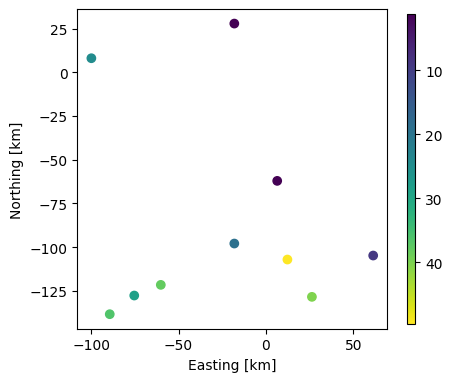

In [28]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

# ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["x"], events["y"], c=events["z"],cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

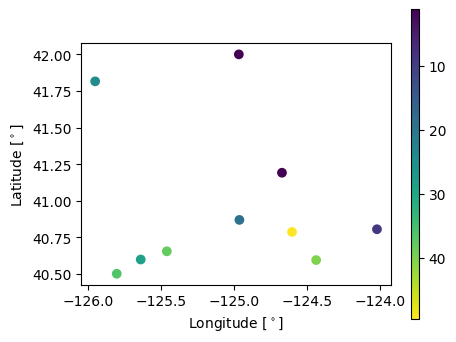

In [29]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

ax.set_xlabel("Longitude [$^\circ$]")
ax.set_ylabel("Latitude [$^\circ$]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["longitude"], events["latitude"], c=events["z"],cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

## Association validation
Get the events from the USGS and compare with the events from the association


In [46]:
client = Client("USGS")
client_waveforms = WaveformClient()
client.get_events(starttime = UTCDateTime("2012-10-14T00:00:00.000000"),
                  endtime   = UTCDateTime("2012-10-14T23:59:59.999999"),
                  minlatitude = 40, maxlatitude = 44, 
                  minlongitude = -125, maxlongitude = -120)


2 Event(s) in Catalog:
2012-10-14T03:08:01.290000Z | +40.721, -124.210 | 1.74 md | manual
2012-10-14T02:39:45.510000Z | +40.301, -124.416 | 1.49 md | manual

In [57]:
# Pick a station 
s = client_waveforms.get_waveforms(network="7D", station="FS09B", channel="BH?", year=2012, month=10, day=14)
s.filter(type='bandpass',freqmin=4,freqmax=15)

3 Trace(s) in Stream:
7D.FS09B..BH1 | 2012-10-14T00:00:00.014700Z - 2012-10-14T23:59:59.994700Z | 50.0 Hz, 4320000 samples
7D.FS09B..BH2 | 2012-10-14T00:00:00.014700Z - 2012-10-14T23:59:59.994700Z | 50.0 Hz, 4320000 samples
7D.FS09B..BHZ | 2012-10-14T00:00:00.014700Z - 2012-10-14T23:59:59.994700Z | 50.0 Hz, 4320000 samples

In [58]:
# Pick a time that shows up in both the USGS catalog and the event data frame from the association above 
time1 = events.loc[1, 'time']

In [59]:
time1

Timestamp('2012-10-14 02:39:44.924554+0000', tz='UTC')

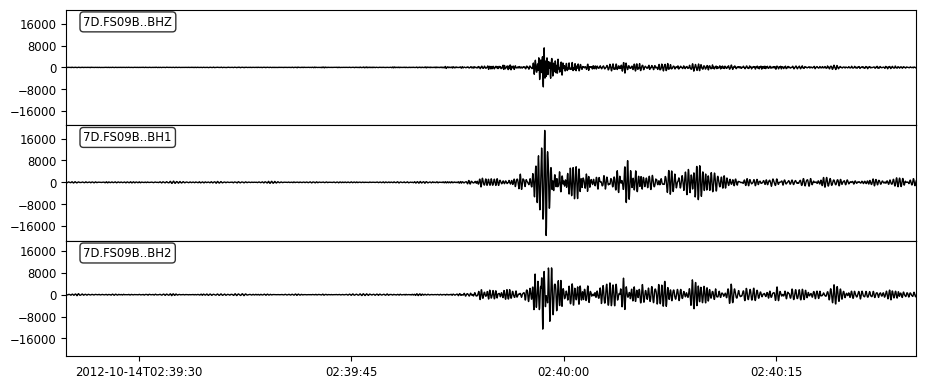

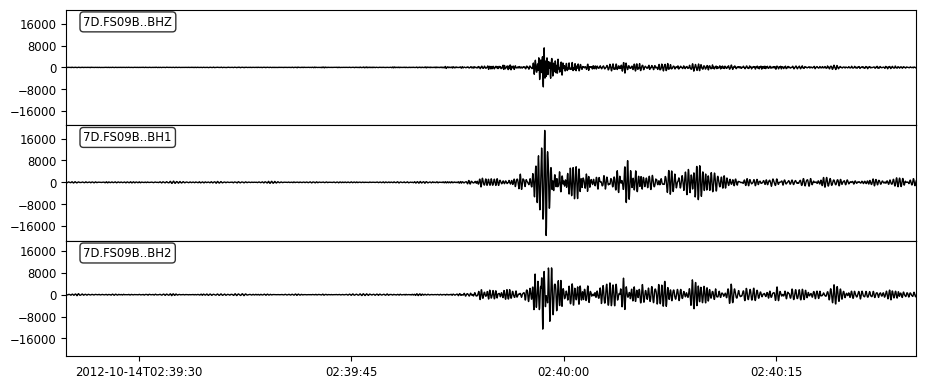

In [60]:
trim_s = s.copy().trim(starttime = UTCDateTime(time1) - 20, 
                endtime = UTCDateTime(time1) + 40)
fig = plt.figure(figsize = (10, 4))
trim_s.plot(fig=fig)

# [ax.axvline(pick.peak_time.matplotlib_date, 
#             linestyle = '--', color = 'r', label = f'{pick.phase} pick') for ax in fig.axes]
# [ax.legend() for ax in fig.axes]

In [61]:
# Pick another time that shows up in both the USGS catalog and the event data frame from the association above 
time2 = events.loc[2, 'time']
time2

Timestamp('2012-10-14 03:08:04.522444+0000', tz='UTC')

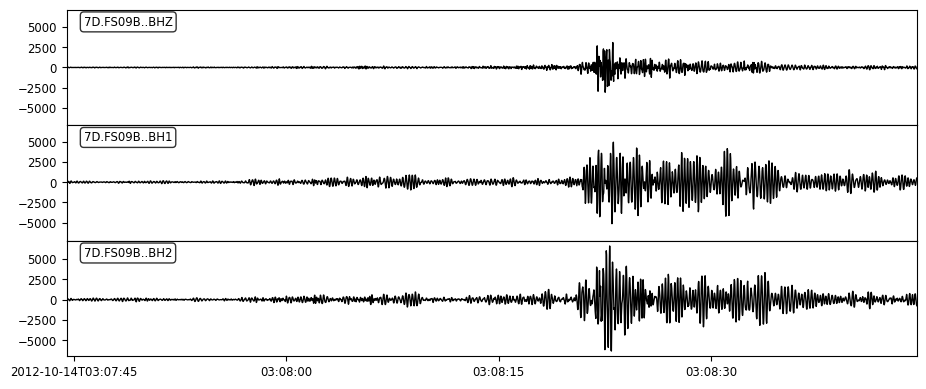

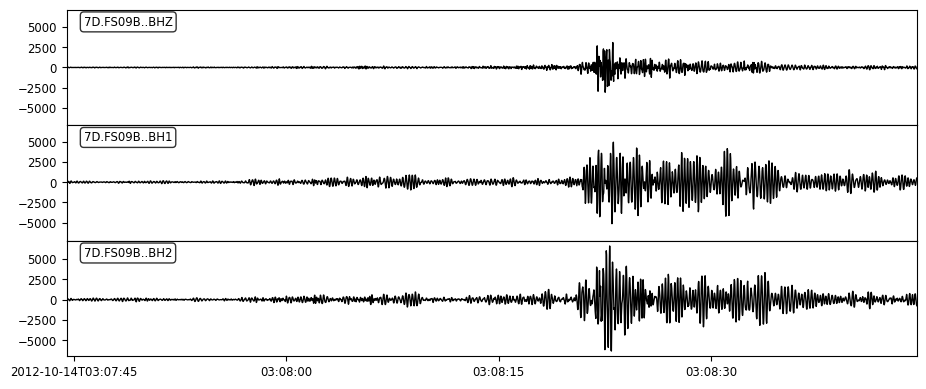

In [63]:
trim_s = s.copy().trim(starttime = UTCDateTime(time2) - 20, 
                endtime = UTCDateTime(time2) + 40)
fig = plt.figure(figsize = (10, 4))
trim_s.plot(fig=fig)

# [ax.axvline(pick.peak_time.matplotlib_date, 
#             linestyle = '--', color = 'r', label = f'{pick.phase} pick') for ax in fig.axes]
# [ax.legend() for ax in fig.axes]

## Other Picks

In [420]:
time = events['time']
time

0   2012-10-14 01:24:03.676530+00:00
1   2012-10-14 02:39:44.924554+00:00
2   2012-10-14 03:08:04.522444+00:00
3   2012-10-14 06:39:14.450545+00:00
4   2012-10-14 07:45:27.532755+00:00
5   2012-10-14 12:02:37.496525+00:00
6   2012-10-14 14:38:21.428889+00:00
7   2012-10-14 16:53:05.638758+00:00
8   2012-10-14 18:16:43.973209+00:00
9   2012-10-14 19:52:13.871130+00:00
Name: time, dtype: datetime64[ns, UTC]

In [418]:
time_possibly_new_events = time.drop(labels=[1,2], axis=0)
time_possibly_new_events

0   2012-10-14 01:24:03.676530+00:00
3   2012-10-14 06:39:14.450545+00:00
4   2012-10-14 07:45:27.532755+00:00
5   2012-10-14 12:02:37.496525+00:00
6   2012-10-14 14:38:21.428889+00:00
7   2012-10-14 16:53:05.638758+00:00
8   2012-10-14 18:16:43.973209+00:00
9   2012-10-14 19:52:13.871130+00:00
Name: time, dtype: datetime64[ns, UTC]

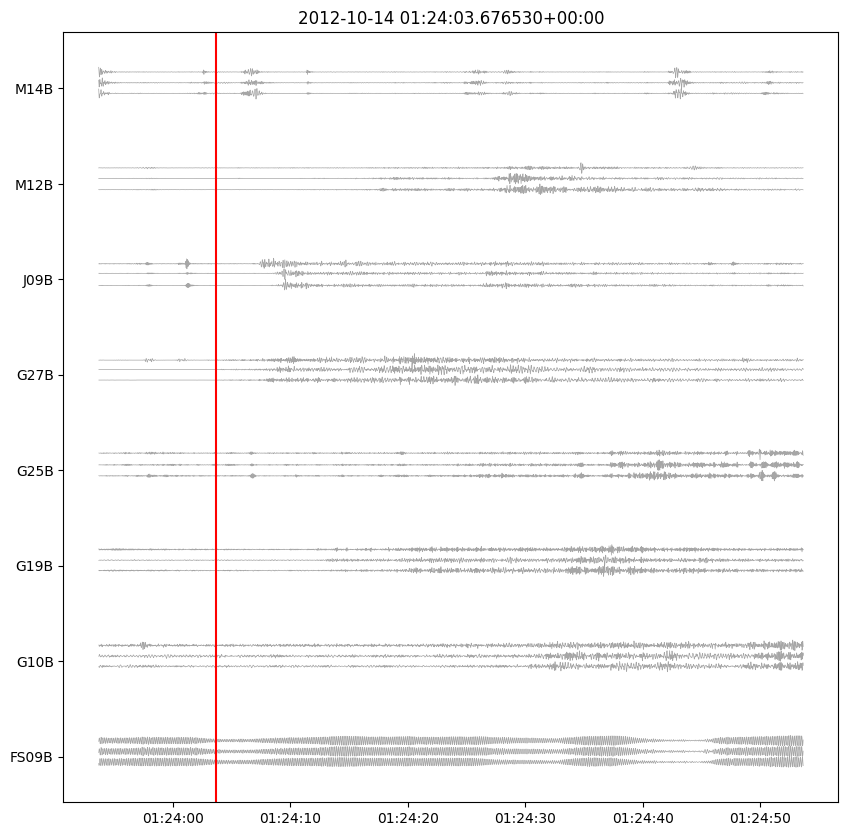

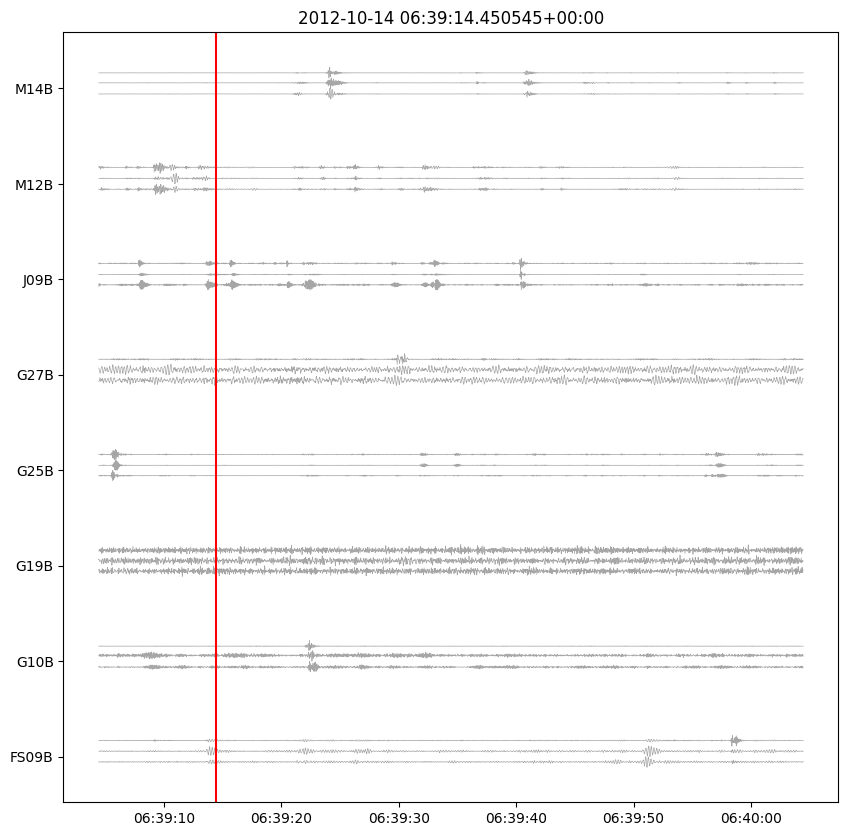

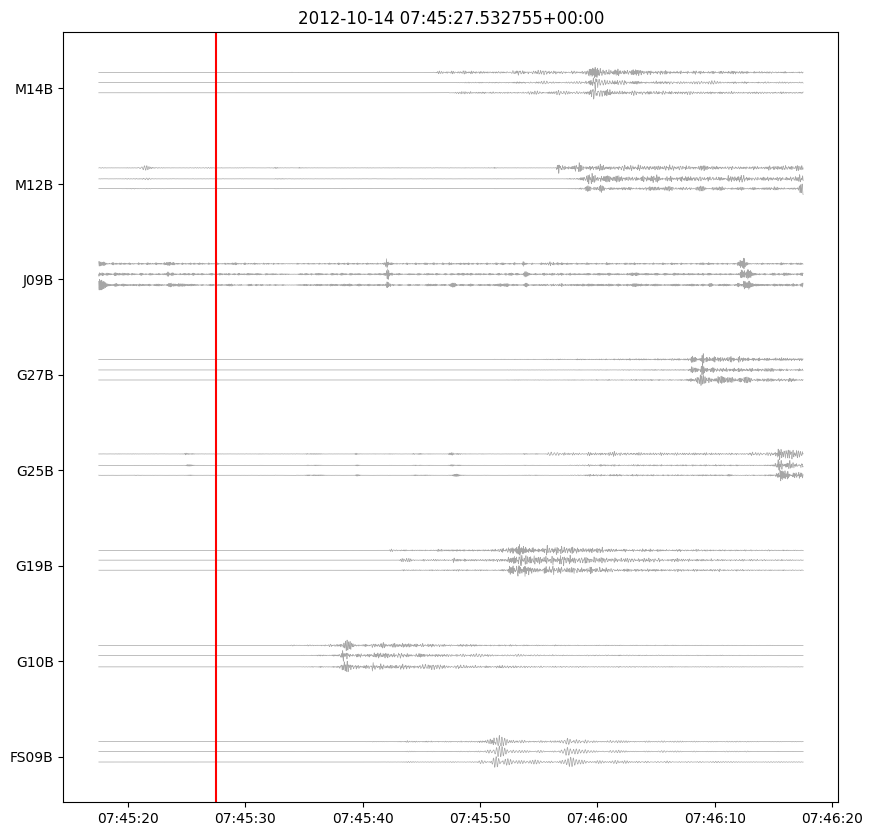

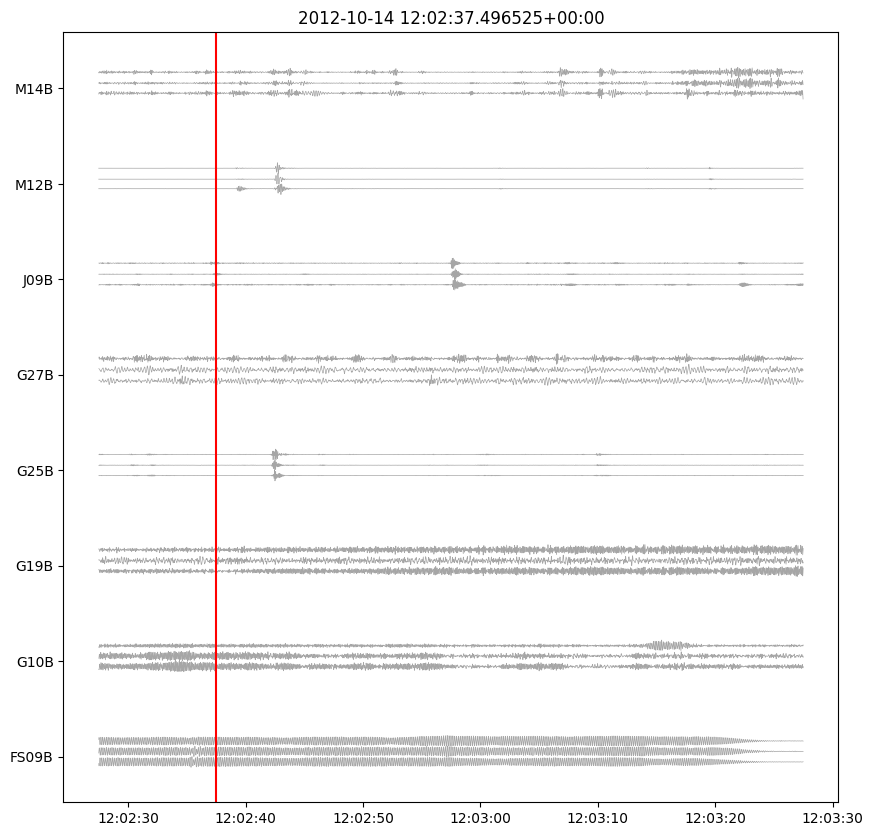

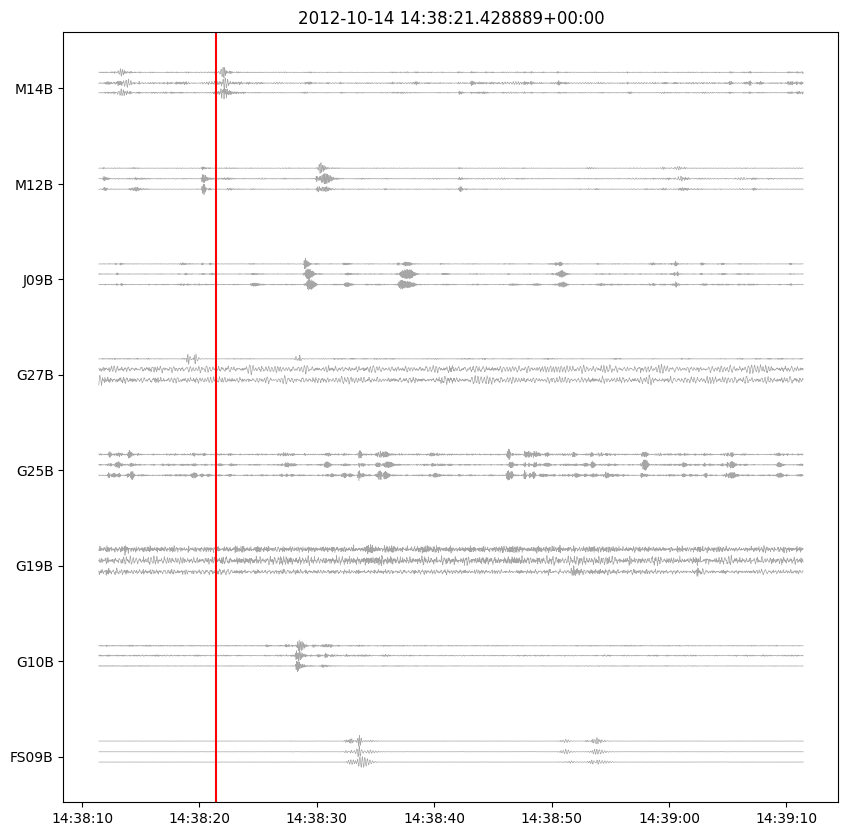

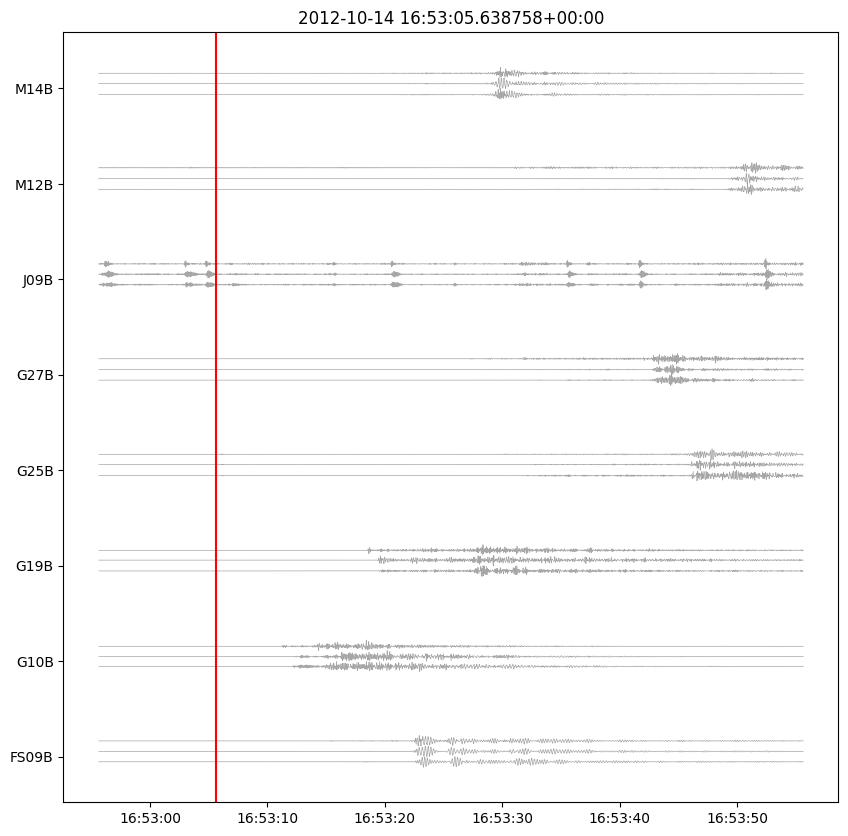

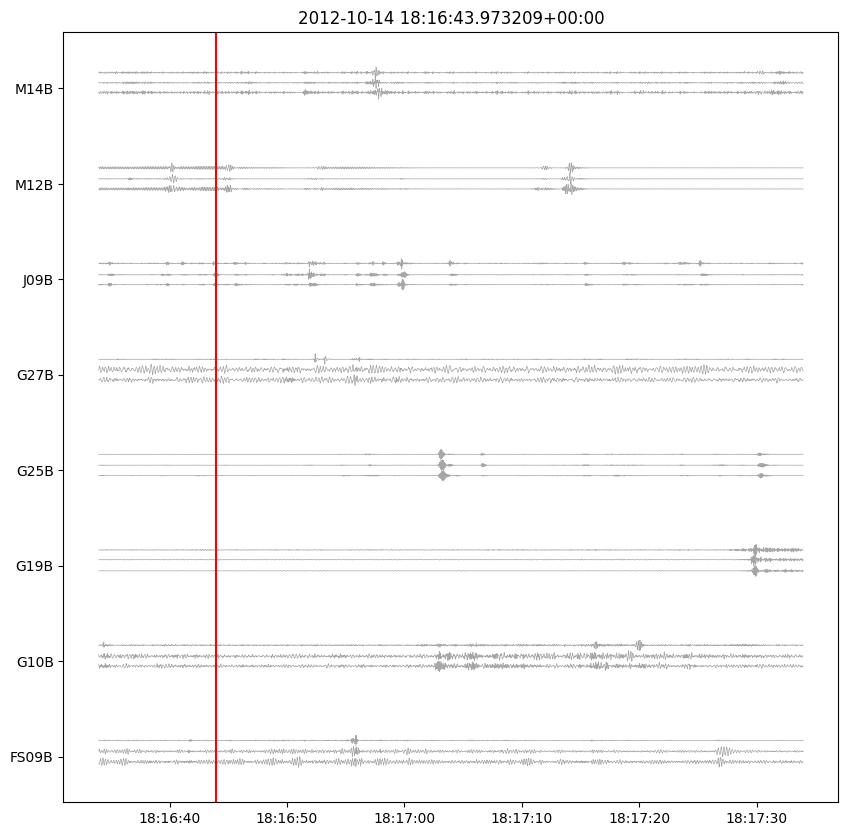

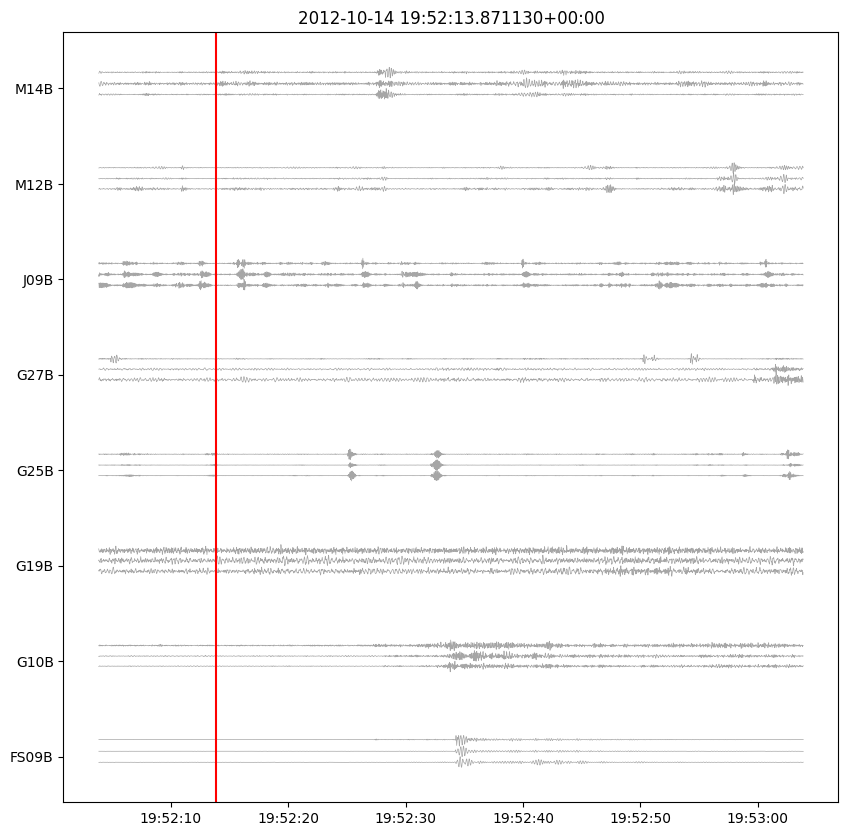

In [421]:
for time in time_possibly_new_events:
    plt.figure(figsize=(10,10))
    for i in range(len(stations)):
        s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
        s = s.select(channel = "[HB]H?")
        s.filter(type='bandpass',freqmin=4,freqmax=15)
        if s[0].stats.channel == 'HH1':
            s = s.resample(50)
        else:
            pass 

        trim_s = s.copy().trim(starttime = UTCDateTime(time) - 10, endtime = UTCDateTime(time) + 50)
        sdata = np.array(trim_s)[:,:]
        sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))
        offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

        for ii in range(len(sdata)):
            offsets1  = np.arange(0,len(sdata))
            plt.plot(trim_s[ii].times(type='utcdatetime'), sdata_norm[ii]+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.7, lw=0.5)    


    plt.yticks(offsets2+1, stations['id'])
    plt.axvline(time,ls='-', c='r')
    plt.title(time)

In [127]:
# Plot waveforms of events picked by the associator but not on the USGS catalog
time4 = events.loc[4, 'time']
time4

Timestamp('2012-10-14 07:45:27.532755+0000', tz='UTC')

In [128]:
# s_FS09B = client_waveforms.get_waveforms(network="7D", station="FS09B", channel="BH?", year=2012, month=10, day=14)
# s_G10B = client_waveforms.get_waveforms(network="7D", station="G10B", channel="BH?", year=2012, month=10, day=14)
# s_G19B = client_waveforms.get_waveforms(network="7D", station="G19B", channel="BH?", year=2012, month=10, day=14)
# s_G25B = client_waveforms.get_waveforms(network="7D", station="G25B", channel="BH?", year=2012, month=10, day=14)
# s_G27B = client_waveforms.get_waveforms(network="7D", station="G27B", channel="BH?", year=2012, month=10, day=14)
# s_J09B = client_waveforms.get_waveforms(network="7D", station="J09B", channel="BH?", year=2012, month=10, day=14)
# s_M12B= client_waveforms.get_waveforms(network="7D", station="M12B", channel="BH?", year=2012, month=10, day=14)
# s_M14B = client_waveforms.get_waveforms(network="7D", station="M14B", channel="BH?", year=2012, month=10, day=14)


In [129]:
# trim_s_FS09B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G10B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G19B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G25B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G27B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_J09B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_M12B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_M14B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)



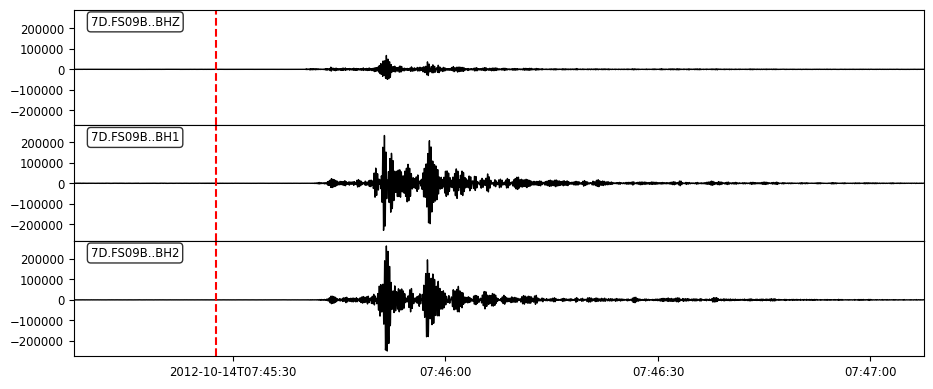

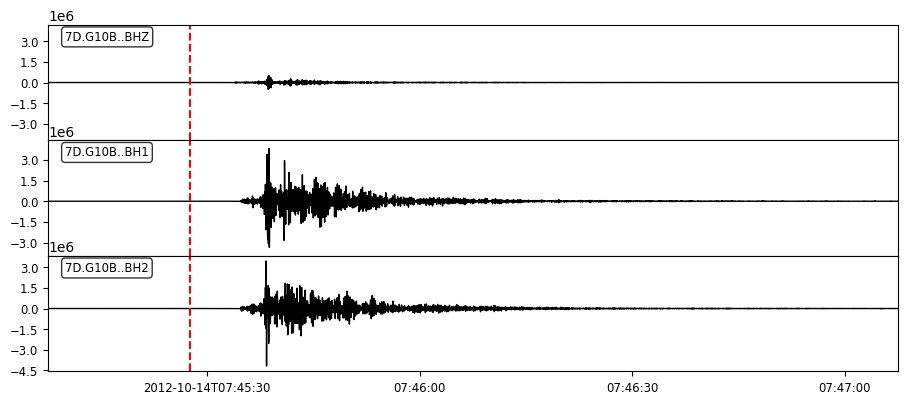

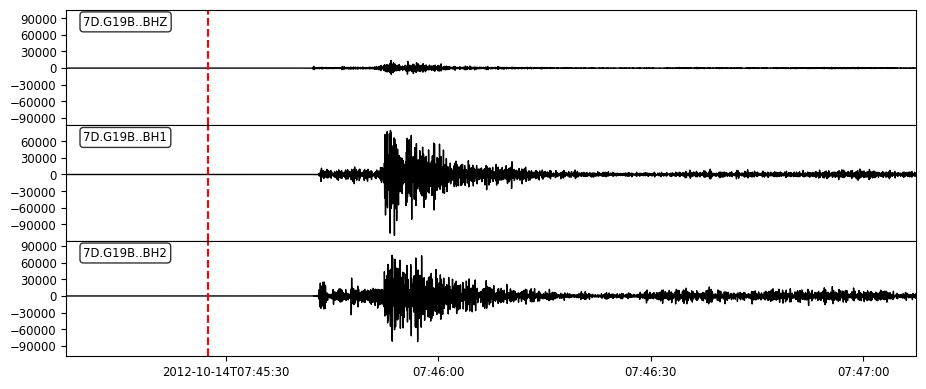

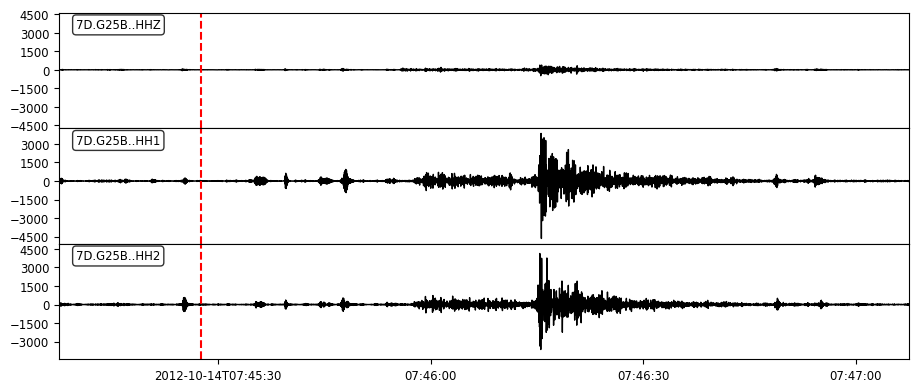

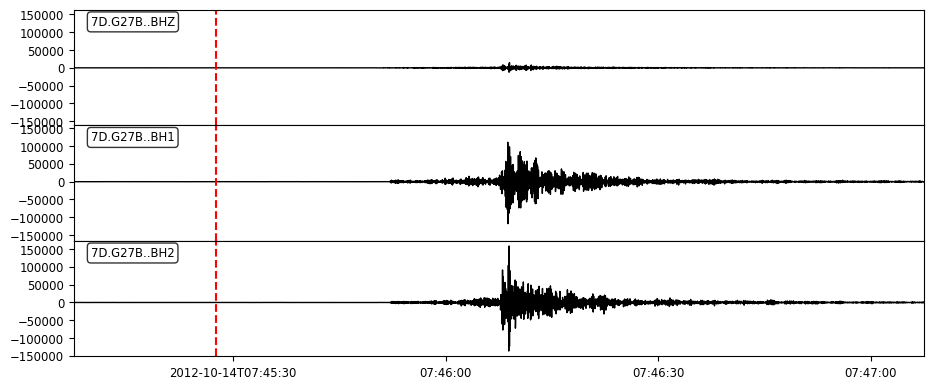

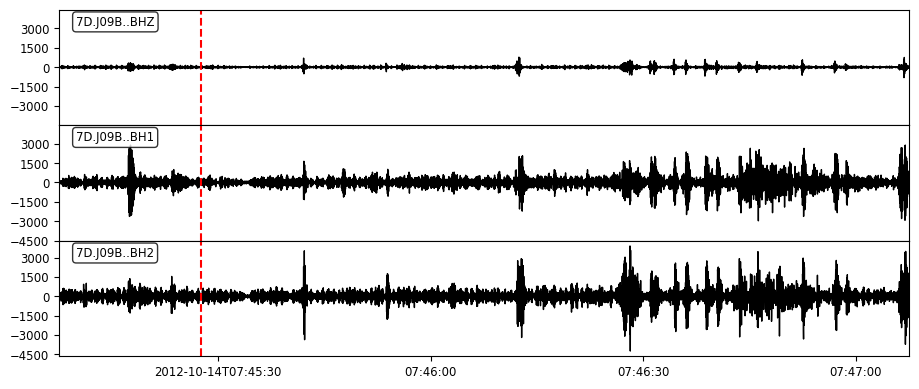

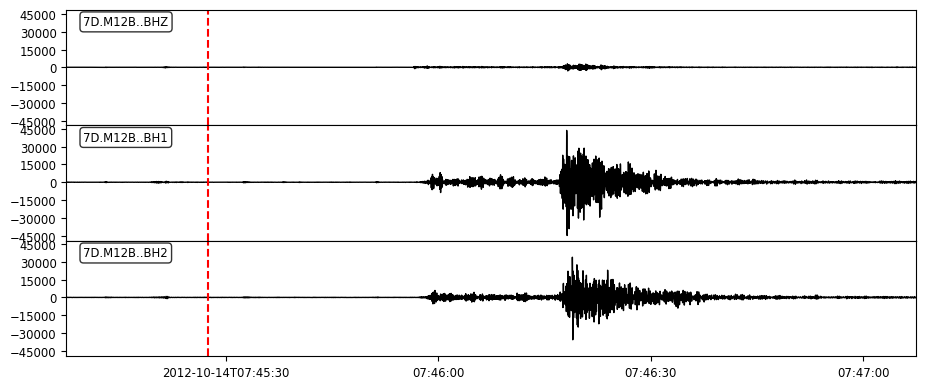

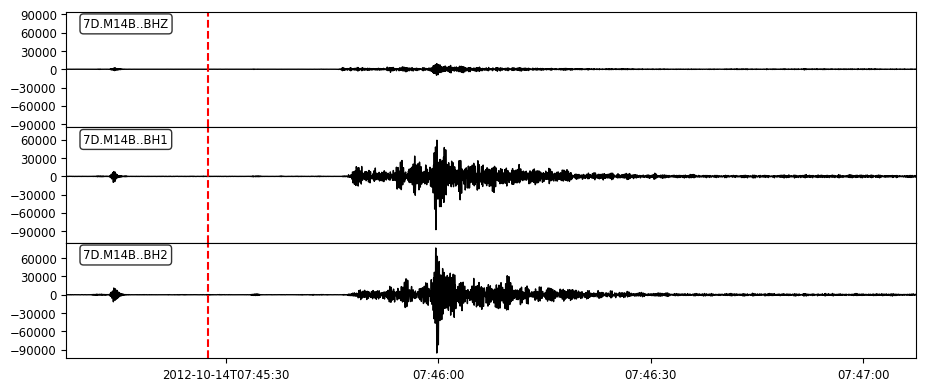

In [174]:
for i, station in enumerate(stations['id']):
    s = client_waveforms.get_waveforms(network="7D", station=station, channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 20, endtime = UTCDateTime(pick_time[4]) + 100)
    fig = plt.figure(figsize=(10,4))
    trim_s.plot(fig=fig)
    [ax.axvline(pick_time[4], 
            linestyle = '--', color = 'r', label = 'pick time') for ax in fig.axes]    


In [190]:
offsets1  = np.arange(0,3)
offsets2 = np.arange(0,2*len(stations),2)



In [191]:
offsets1

array([0, 1, 2])

In [213]:
offsets2 = np.arange(0,2*10000*len(stations),2*10000)

offsets2

array([     0,  20000,  40000,  60000,  80000, 100000, 120000, 140000])

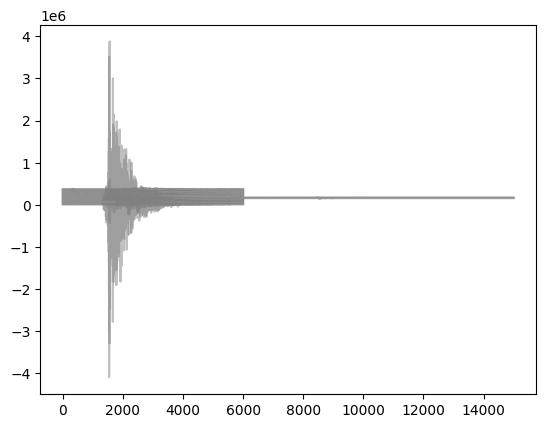

In [216]:
plt.figure()
offsets2 = np.arange(0,5*10000*len(stations),5*10000)

for i, station in enumerate(stations['id']):
    s = client_waveforms.get_waveforms(network="7D", station=station, channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 20, endtime = UTCDateTime(pick_time[4]) + 100)
    sdata = np.array(trim_s)[:,:]
    for ii in range(len(sdata)):
        offsets1  = np.arange(0,10000*len(sdata),10000)
        plt.plot(sdata[ii].T+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.5)   


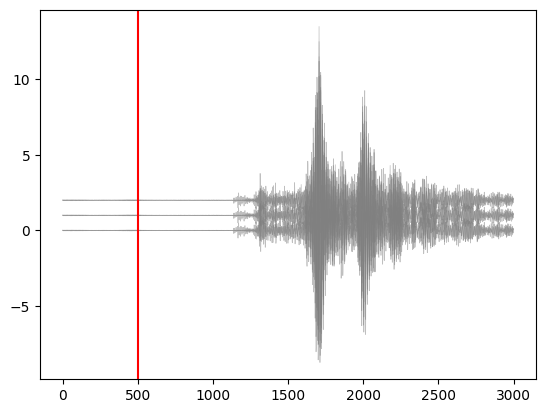

In [285]:
offsets2 = np.arange(0,5*100000*len(stations),5*100000)


s = client_waveforms.get_waveforms(network="7D", station=stations['id'][0], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
sampling_rate = s[0].stats.sampling_rate
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
sdata_norm = (sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

for ii in range(len(sdata)):
    offsets1  = np.arange(0,len(sdata))
    plt.plot(sdata_norm.T+offsets1[ii], color = 'gray', alpha=0.5, lw=0.5)

plt.axvline(10*sampling_rate,ls='-', c='r')
    


In [246]:
sdata.mean()

0.10028120015905434

In [202]:
s[0].stats.sampling_rate*120

6000.0

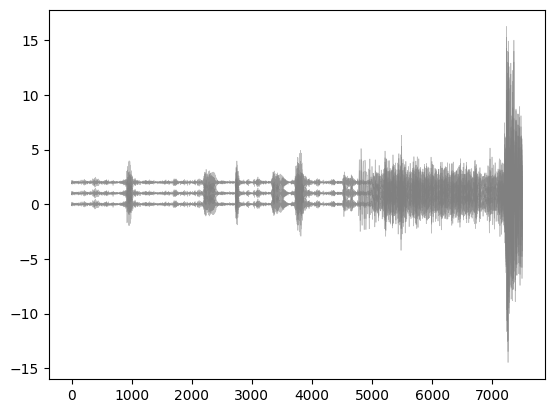

In [296]:
s = client_waveforms.get_waveforms(network="7D", station=stations['id'][3], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
sdata_norm = (sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

for ii in range(len(sdata)):
    offsets1  = np.arange(0,len(sdata))
    plt.plot(sdata_norm.T+offsets1[ii], color = 'gray', alpha=0.5, lw=0.5)

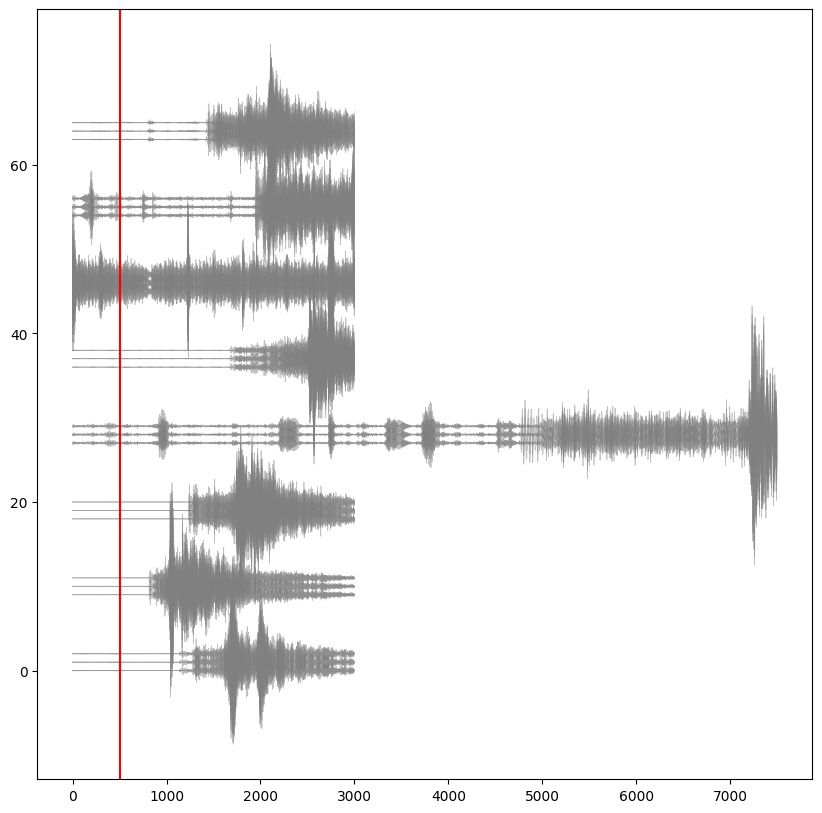

In [293]:
plt.figure(figsize=(10,10))
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

for i in range(len(stations)):
    s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
    sdata = np.array(trim_s)[:,:]
    sdata_norm = (sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

    for ii in range(len(sdata)):
        offsets1  = np.arange(0,len(sdata))
        plt.plot(sdata_norm.T+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.5, lw=0.5)    

plt.axvline(10*sampling_rate,ls='-', c='r')


In [289]:
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))
offsets2

array([ 0,  9, 18, 27, 36, 45, 54, 63])

In [257]:
np.mean(sdata, axis=1, keepdims=True)

array([[ 0.28159811],
       [ 0.08107856],
       [-0.06183307]])

In [258]:
sdata

array([[ 225.73644077,  572.92599194,  565.73796524, ...,  323.88928169,
         696.64947483,  618.95645024],
       [ 126.90535892, -121.26901623, -287.73565114, ...,  416.023985  ,
         633.80379941,  679.68552563],
       [ -18.32771556, -165.57266863, -197.27787814, ...,  -88.33525295,
         -58.2401598 ,   84.27217672]])

In [259]:
np.mean(sdata[0])

0.2815981127464598

In [274]:
(sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

array([[ 0.01109954,  0.02819229,  0.02783842, ...,  0.01593178,
         0.03428342,  0.03045846],
       [ 0.00625783, -0.00598772, -0.01420161, ...,  0.02052368,
         0.03126949,  0.03353341],
       [-0.00437663, -0.03965754, -0.04725433, ..., -0.02115092,
        -0.01393993,  0.02020701]])

In [267]:
(225.73644077-0.28159811)/20312.08876045

0.011099540048239

In [265]:
np.std(sdata, axis=1, keepdims=True) 

array([[20312.08876045],
       [20266.48831034],
       [ 4173.50194367]])

In [298]:
sdata

array([[   54.07488514,    28.19145444,    -1.8569305 , ...,
          323.11438552,   493.75848362,   487.82926381],
       [  -13.74717178,   -28.21786457,   -36.45083586, ...,
        -1092.23769618,  -794.84122861,  -459.35419386],
       [   -2.2280203 ,    -3.58676509,    -4.85413293, ...,
            4.9663455 ,    33.22970956,    45.54326683]])

In [297]:
np.max(sdata, axis=1, keepdims=True)

array([[3851.53261126],
       [4130.31546969],
       [ 379.40064494]])

In [299]:
np.min(sdata, axis=1, keepdims=True)

array([[-4647.80400942],
       [-3638.41150606],
       [ -479.2984012 ]])

In [300]:
(sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))

array([[0.5532054 , 0.55016005, 0.54662467, ..., 0.58485957, 0.60493692,
        0.60423931],
       [0.46657121, 0.46470852, 0.46364877, ..., 0.32774659, 0.36602783,
        0.40921213],
       [0.55557344, 0.55399111, 0.55251519, ..., 0.56395165, 0.59686582,
        0.6112056 ]])

3001
3001
3001
3000
3001
3001
3001
3001


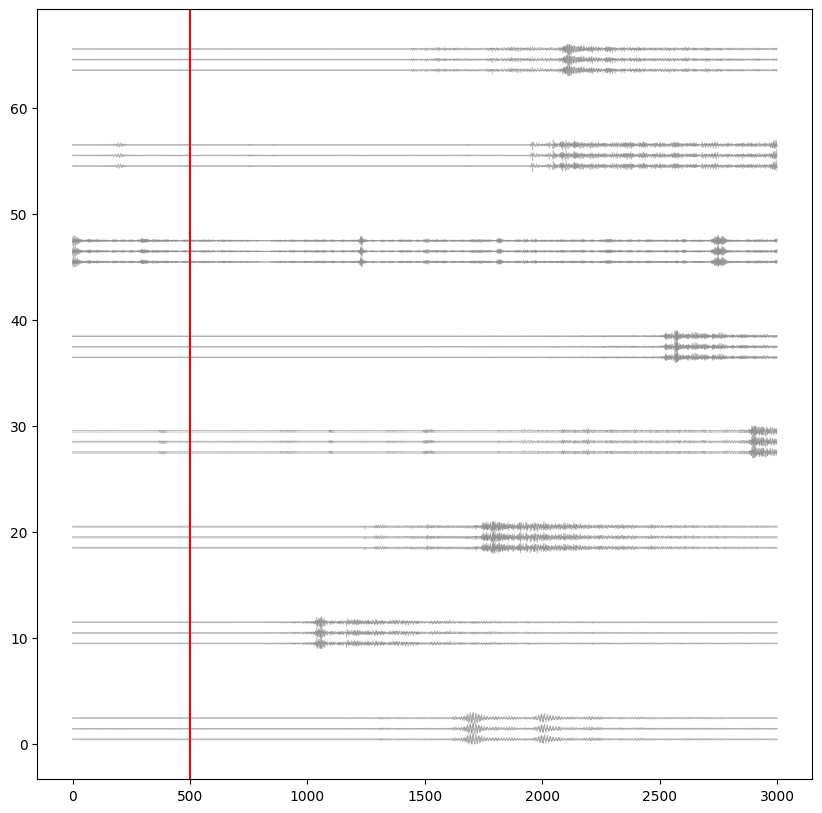

In [372]:
plt.figure(figsize=(10,10))
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

for i in range(len(stations)):
    s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
    sdata = np.array(trim_s)[:,:]
    if s[0].stats.channel == 'HH1':
        new_rate = 50
        number_of_samples = round(len(sdata[0]) * float(new_rate) /s[0].stats.sampling_rate)
        sdata = signal.resample(sdata, number_of_samples, axis=-1)
    else:
        pass 
    print(len(sdata[-1]))
    sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))
    for ii in range(len(sdata)):
        offsets1  = np.arange(0,len(sdata))
        plt.plot(sdata_norm.T+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.5, lw=0.5)    

plt.axvline(10*sampling_rate,ls='-', c='r')
# plt.xlim(0,3000)


In [345]:
s = client_waveforms.get_waveforms(network="7D", station=stations['id'][3], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))

In [304]:
UTCDateTime(pick_time[4]) - 10

2012-10-14T07:45:17.532755Z

In [306]:
UTCDateTime(pick_time[4]) + 50

2012-10-14T07:46:17.532755Z

In [322]:
s[0].stats.sampling_rate

125.0

In [313]:
s[0].stats.channel

'HH1'

In [325]:
len(s[-1])

10800000

In [327]:
s[0].stats.sampling_rate

50.0

In [316]:
s[0].stats.channel

'BH1'

In [328]:
len(s[-1])

4320000

In [334]:
s = signal.decimate(s, 125/50, axis=-1)

TypeError: 'float' object cannot be interpreted as an integer

In [347]:
np.array(s)

array([[ 6.53523096e+03,  4.61324772e+04,  1.52231888e+05, ...,
        -1.06255470e+01, -9.86627295e+00, -6.02345531e+00],
       [ 6.53190434e+03,  4.61089415e+04,  1.52153909e+05, ...,
         1.37355550e+01,  1.90139271e+01,  2.01969418e+01],
       [ 6.52818872e+03,  4.60829400e+04,  1.52069132e+05, ...,
         3.14802318e+00,  1.09117554e+00, -2.14952779e-01]])

In [336]:
int(125/50)

2

In [341]:
new_rate = 50
number_of_samples = round(len(s[0]) * float(new_rate) / 125)
number_of_samples

4320000

In [343]:
s = signal.resample(s, number_of_samples, axis=-1)
len(s[-1])

4320000

In [344]:
s

array([[  2462.38623471, 233044.98439301, 464110.53741506, ...,
          1483.08879554,  -2179.54788349,   3318.34370584],
       [  2468.8118825 , 232923.5218896 , 463865.01591711, ...,
          1457.49361998,  -2182.27131719,   3345.41508889],
       [  2461.03433155, 232796.35085515, 463629.50754207, ...,
          1486.64472459,  -2165.8465117 ,   3327.18366886]])

In [388]:
s = client_waveforms.get_waveforms(network="7D", station=stations['id'][3], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
print(len(sdata[-1]))

new_rate = 50
number_of_samples = round(len(sdata[0]) * float(new_rate) /s[0].stats.sampling_rate)
sdata = signal.resample(sdata, number_of_samples, axis=-1)
print(len(sdata[-1]))

7501
3000


In [400]:
trim_s[0].times(reftime=UTCDateTime(pick_time[4]) - 10)

array([-2.8860000e-03,  1.7114000e-02,  3.7114000e-02, ...,
        5.9957114e+01,  5.9977114e+01,  5.9997114e+01])

In [403]:
UTCDateTime(pick_time[4])

2012-10-14T07:45:27.532755Z

In [405]:
trim_s.trigger('recstalta',sta=1, lta=4)

3 Trace(s) in Stream:
7D.M14B..BH1 | 2012-10-14T07:45:17.529869Z - 2012-10-14T07:46:17.529869Z | 50.0 Hz, 3001 samples
7D.M14B..BH2 | 2012-10-14T07:45:17.529869Z - 2012-10-14T07:46:17.529869Z | 50.0 Hz, 3001 samples
7D.M14B..BHZ | 2012-10-14T07:45:17.529869Z - 2012-10-14T07:46:17.529869Z | 50.0 Hz, 3001 samples

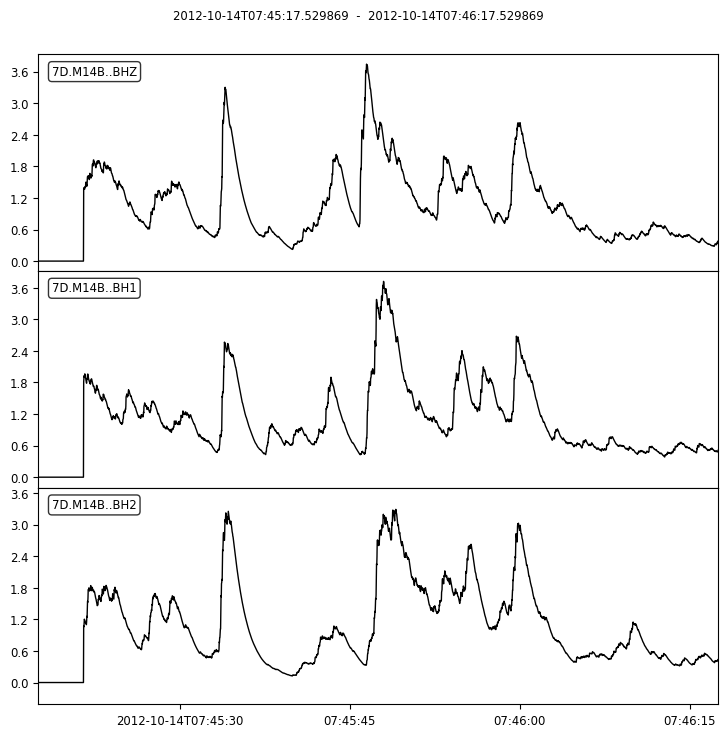

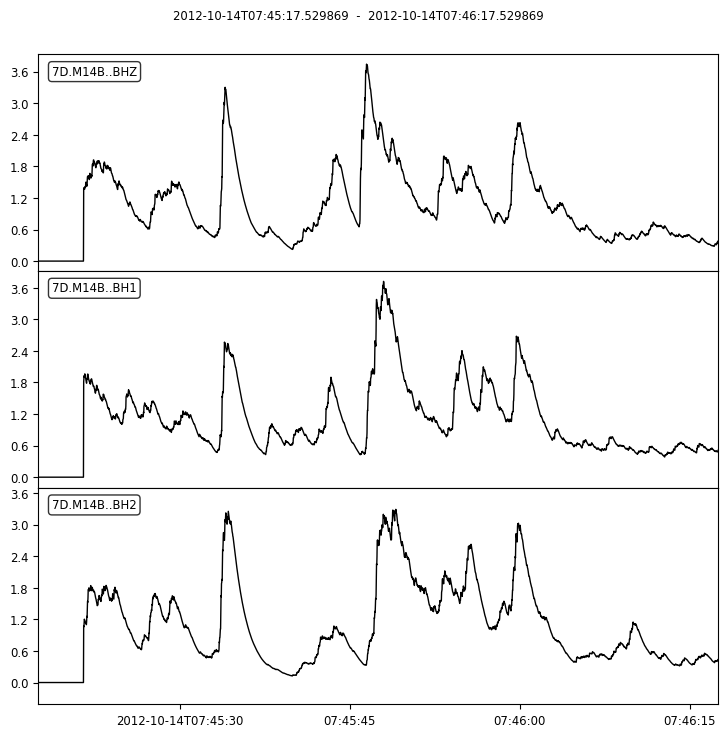

In [406]:
trim_s.plot()

Text(0.5, 1.0, '2012-10-14 07:45:27.532755+00:00')

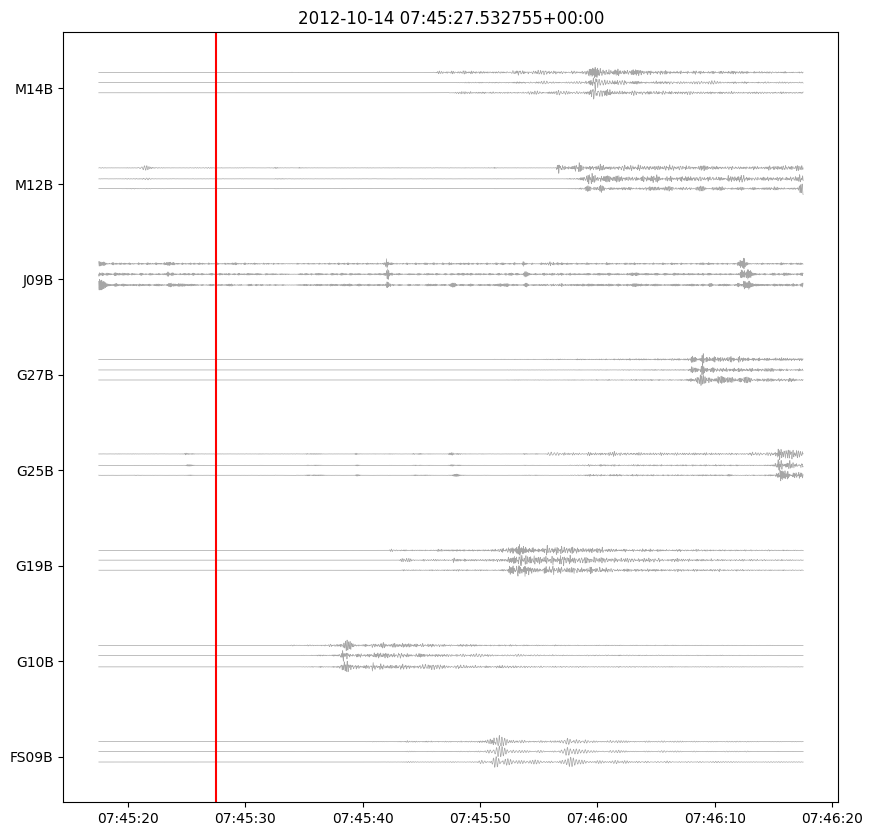

In [408]:
plt.figure(figsize=(10,10))
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

for i in range(len(stations)):
    s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    if s[0].stats.channel == 'HH1':
        s = s.resample(50)
    else:
        pass 
    
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
    sdata = np.array(trim_s)[:,:]
    sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))
    
    for ii in range(len(sdata)):
        offsets1  = np.arange(0,len(sdata))
        plt.plot(trim_s[ii].times(type='utcdatetime'), sdata_norm[ii]+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.7, lw=0.5)    
    

plt.yticks(offsets2+1, stations['id'])
plt.axvline(pick_time[4],ls='-', c='r')
plt.title(pick_time[4])

# plt.xlim(0,3000)


In [374]:
np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

array([ 0,  9, 18, 27, 36, 45, 54, 63])

In [375]:
stations['id']

0    FS09B
1     G10B
2     G19B
3     G25B
4     G27B
5     J09B
6     M12B
7     M14B
Name: id, dtype: object

In [379]:
all_picks, all_detections = model.classify(sdata)

NameError: name 'model' is not defined

In [381]:
picks_G25B =  pd.read_csv("~/notebooks/data/catalogs_elep_filtered_stations_20121001_to_20121031/G25B_20121014.csv",index_col=0)
picks_G25B

event_id source_type station_network_code station_channel_code  \
0                                          7D                        
1                                          7D                        
2                                          7D                        
3                                          7D                        
4                                          7D                        
..       ...         ...                  ...                  ...   
699                                        7D                        
700                                        7D                        
701                                        7D                        
702                                        7D                        
703                                        7D                        

    station_code  station_location_code  station_latitude_deg  \
0           G25B                    NaN             41.919899   
1           G25B                    NaN             41.919899   
2           G25B                    NaN             41.919899   
3           G25B                    NaN             41.919899   
4           G25B                    NaN             41.919899   
..           ...                    ...                   ...   
699         G25B                    NaN             41.919899   
700         G25B                    NaN             41.919899   
701         G25B                    NaN             41.919899   
702         G25B                    NaN             41.919899   
703         G25B                    NaN             41.919899   

     station_longitude_deg  station_elevation_m trace_name  \
0              -124.586098               -430.0              
1              -124.586098               -430.0              
2              -124.586098               -430.0              
3              -124.586098               -430.0              
4              -124.586098               -430.0              
..                     ...                  ...        ...   
699            -124.586098               -430.0              
700            -124.586098               -430.0              
701            -124.586098               -430.0              
702            -124.586098               -430.0              
703            -124.586098               -430.0              

     trace_sampling_rate_hz             trace_start_time  \
0                     125.0  2012-10-14T00:00:00.005500Z   
1                     125.0  2012-10-14T00:00:00.005500Z   
2                     125.0  2012-10-14T00:00:00.005500Z   
3                     125.0  2012-10-14T00:00:00.005500Z   
4                     125.0  2012-10-14T00:00:00.005500Z   
..                      ...                          ...   
699                   125.0  2012-10-14T00:00:00.005500Z   
700                   125.0  2012-10-14T00:00:00.005500Z   
701                   125.0  2012-10-14T00:00:00.005500Z   
702                   125.0  2012-10-14T00:00:00.005500Z   
703                   125.0  2012-10-14T00:00:00.005500Z   

    trace_S_arrival_sample trace_P_arrival_sample trace_S_onset trace_P_onset  \
0                                                                               
1                                                                               
2                                                                               
3                                                                               
4                                                                               
..                     ...                    ...           ...           ...   
699                                                                             
700                                                                             
701                                                                             
702                                                                             
703                      

In [382]:
pick_time[4]

Timestamp('2012-10-14 07:45:27.532755+0000', tz='UTC')

## Plot the associated events on a map

/tmp/ipykernel_3174063/41563832.py:7: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x = events_morton_lon, y = events_morton_lat,
/tmp/ipykernel_3174063/41563832.py:9: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x = events_longitude, y = events_latitude,
/tmp/ipykernel_3174063/41563832.py:11: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x = events_jdf_lon, y = events_jdf_lat,
/tmp/ipykernel_3174063/41563832.py:13: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x = events_cascadia_lon, y = events_cascadia_lat,


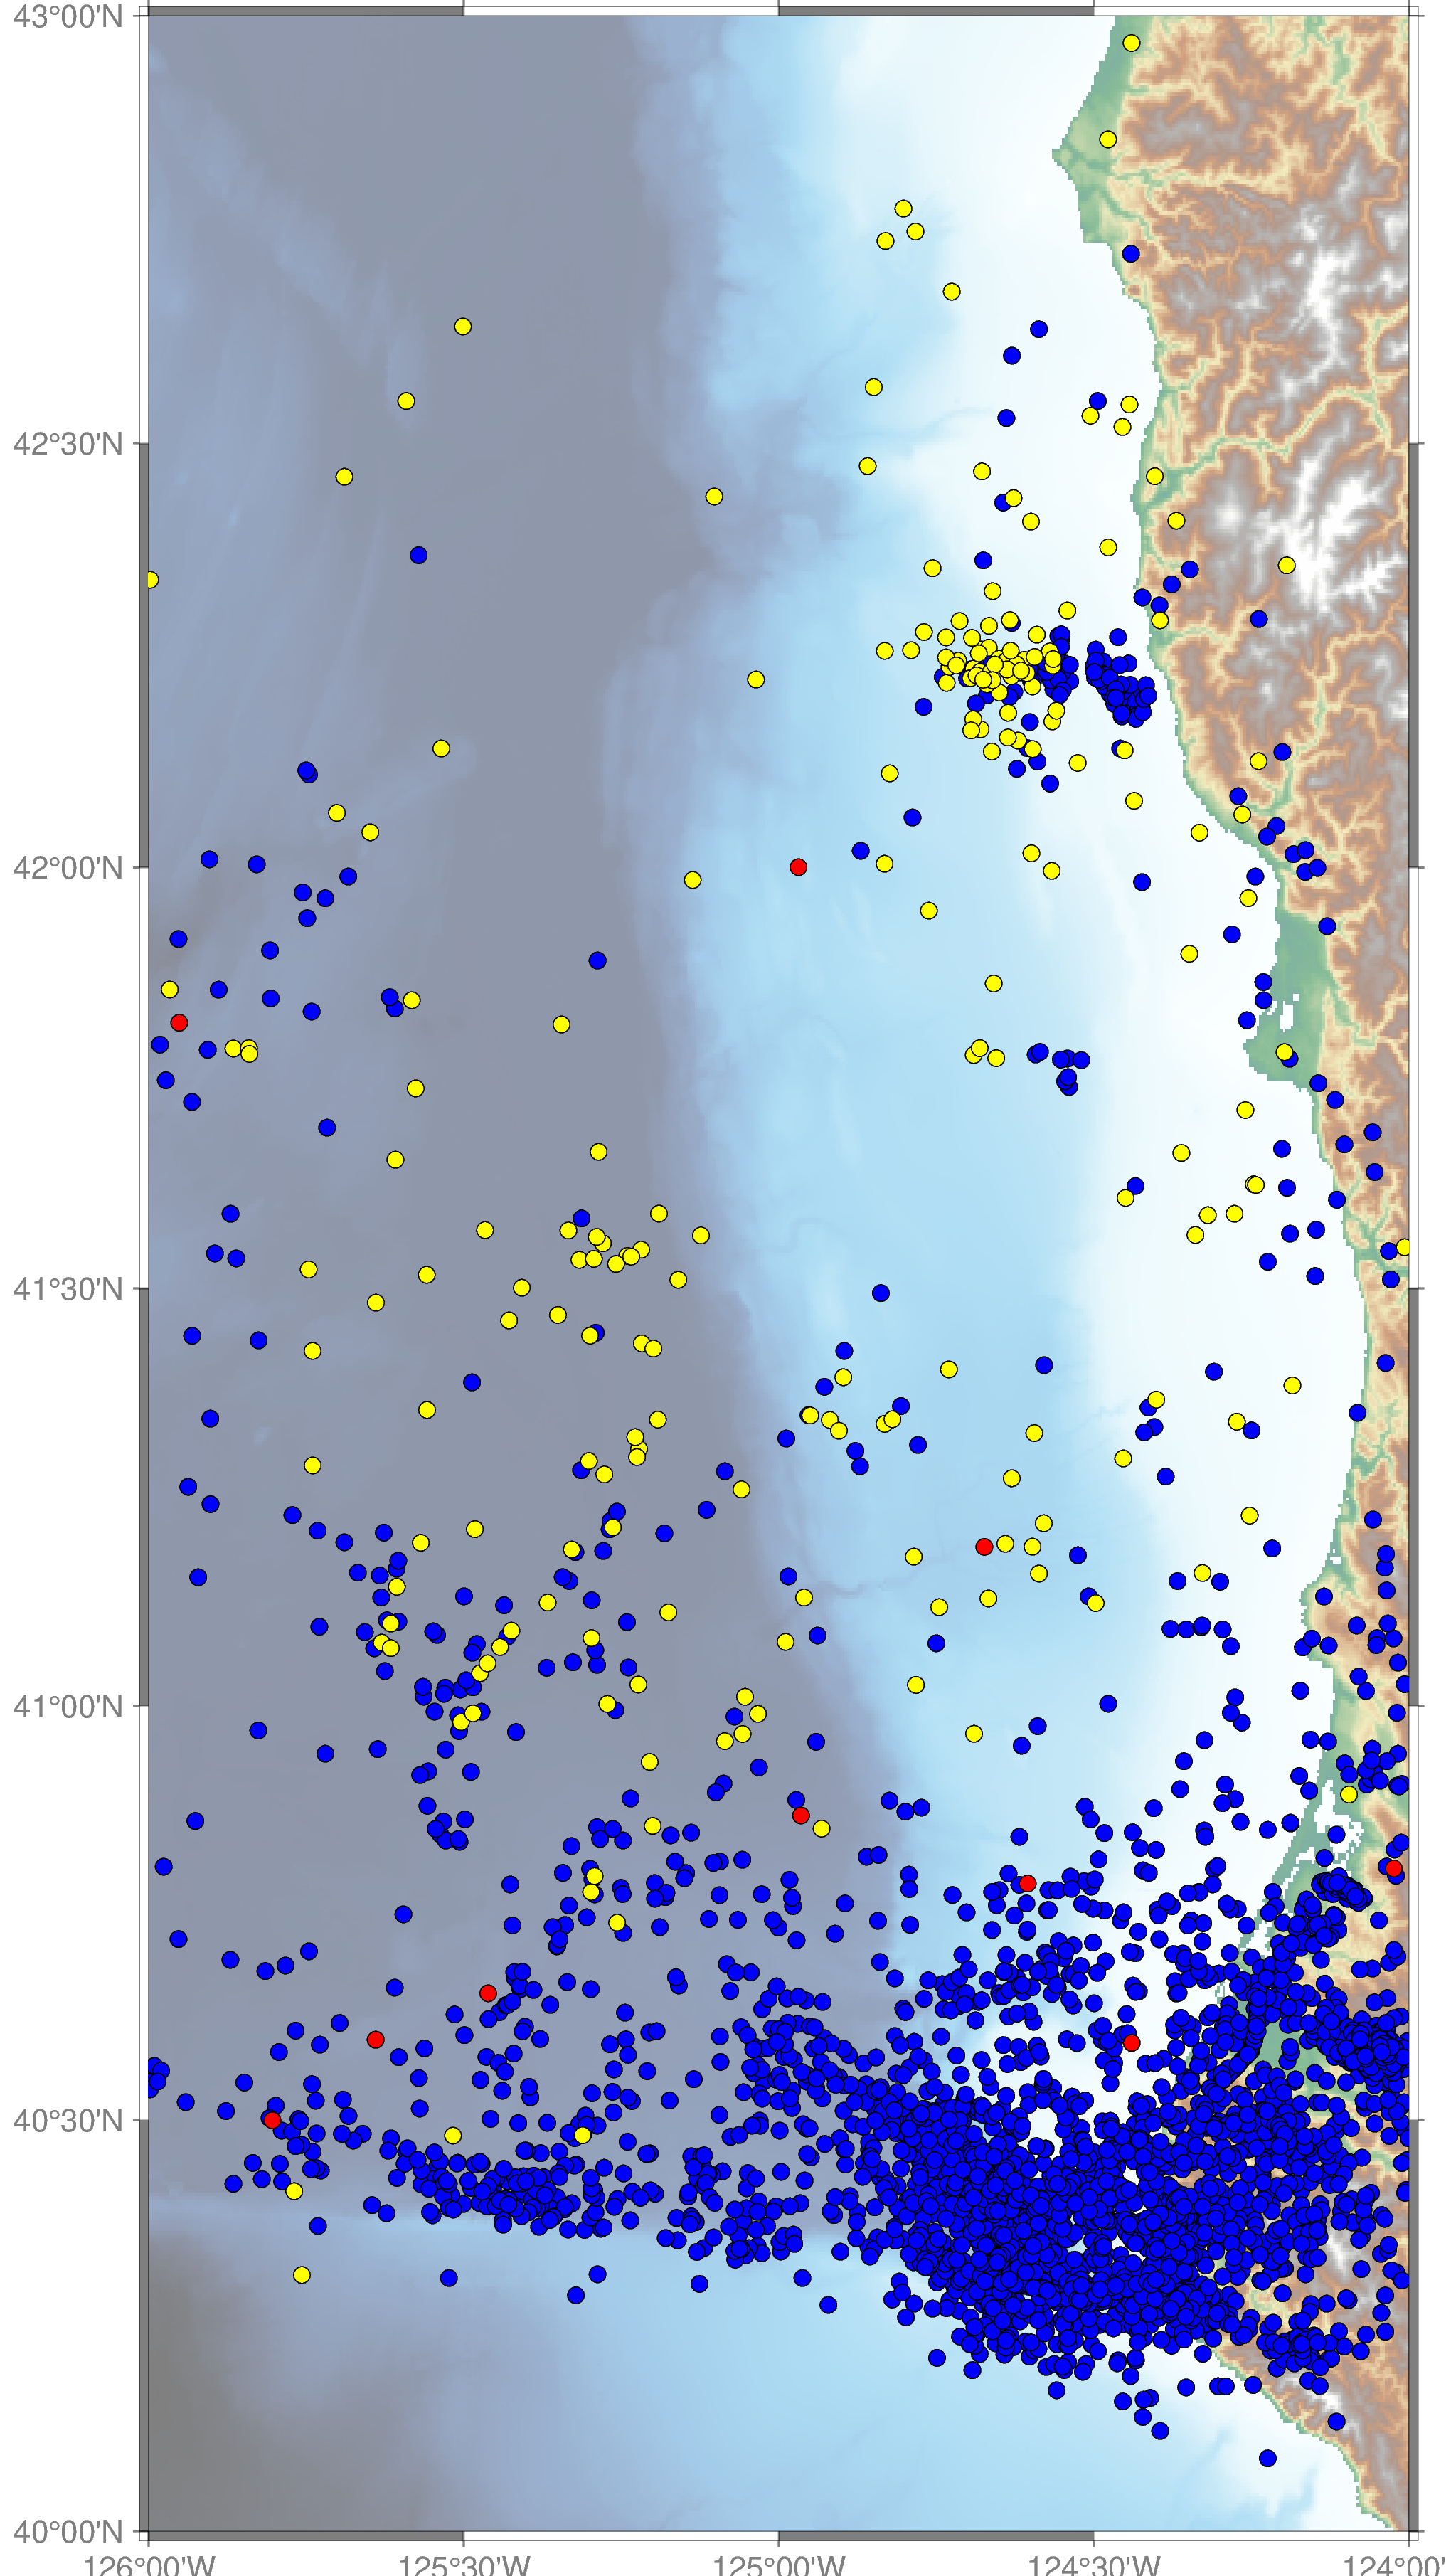

In [75]:
import pygmt

fig = pygmt.Figure()
grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[-126, -124, 40, 43])
# fig.shift_origin(yshift="10c")
fig.grdimage(grid=grid, projection="M15c", frame="a", cmap="geo", transparency = 50)
fig.plot(x = events_morton_lon, y = events_morton_lat,  
         color = 'blue', size = size_morton, style = "c", pen = "black")
fig.plot(x = events_longitude, y = events_latitude,  
         color = 'red', size = size, style = "c", pen = "black")
fig.plot(x = events_jdf_lon, y = events_jdf_lat,  
         color = 'yellow', size = size_jdf, style = "c", pen = "black")
fig.plot(x = events_cascadia_lon, y = events_cascadia_lat,  
         color = 'yellow', size = size_cascadia, style = "c", pen = "black")
# # Draw a line between two events that we consider to be the same event 
# fig.plot(x = [, y = events_cascadia_lat,  
#          color = 'yellow', size = size_cascadia, style = "c", pen = "black")

fig.show()

In [39]:
events_longitude = events['longitude']
events_longitude

0   -125.951392
1   -124.439672
2   -124.604763
3   -124.964663
4   -125.803638
5   -124.968426
6   -125.639653
7   -125.460940
8   -124.023617
9   -124.673457
Name: longitude, dtype: float64

In [40]:
events_latitude = events['latitude']
events_latitude 

0    41.815873
1    40.593306
2    40.785806
3    40.868056
4    40.499693
5    42.000358
6    40.597160
7    40.653305
8    40.804200
9    41.190790
Name: latitude, dtype: float64

In [198]:
# Assign the size of 0.5 to all the points for the associated events 

size = np.zeros(len(events))
for i in range(len(events)):
    size[i] = 0.2

In [199]:
size_jdf = np.zeros(len(events_jdf))
for i in range(len(events_jdf)):
    size_jdf[i] = 0.2

In [200]:
size_cascadia = np.zeros(len(events_cascadia))
for i in range(len(events_cascadia)):
    size_cascadia[i] = 0.2

In [201]:
size_morton = np.zeros(len(events_morton))
for i in range(len(events_morton)):
    size_morton[i] = 0.2

In [195]:
len(size_cascadia)

0

In [38]:
size

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [25]:
events

idx                             time          x           y          z  \
0    0 2012-10-14 01:24:03.676530+00:00 -99.823478    8.014299  24.609375   
1    1 2012-10-14 02:39:44.924554+00:00  26.269336 -128.412984  40.234375   
2    2 2012-10-14 03:08:04.522444+00:00  12.259024 -107.072404  49.609375   
3    3 2012-10-14 06:39:14.450545+00:00 -18.096654  -97.926441  19.140625   
4    4 2012-10-14 07:45:27.532755+00:00 -89.315744 -138.321111  36.328125   
5    5 2012-10-14 12:02:37.496525+00:00 -18.096654   27.830552   1.171875   
6    6 2012-10-14 14:38:21.428889+00:00 -75.305431 -127.650821  28.515625   
7    7 2012-10-14 16:53:05.638758+00:00 -60.127592 -121.553512  37.890625   
8    8 2012-10-14 18:16:43.973209+00:00  61.295118 -104.785913   8.984375   
9    9 2012-10-14 19:52:13.871130+00:00   6.421393  -62.104752   1.171875   

   picks   latitude   longitude      depth  
0      4  41.815873 -125.951392  24.609375  
1      5  40.593306 -124.439672  40.234375  
2      7  40.785806 -124.604763  49.609375  
3      4  40.868056 -124.964663  19.140625  
4     14  40.499693 -125.803638  36.328125  
5      4  42.000358 -124.968426   1.171875  
6      4  40.597160 -125.639653  28.515625  
7     14  40.653305 -125.460940  37.890625  
8      4  40.804200 -124.023617   8.984375  
9      4  41.190790 -124.673457   1.171875

In [32]:
type(events_latitude.shape)

tuple

In [31]:
events_longitude.shape

(10,)

## Load Data from Ian Stone's Paper

In [196]:
events_cascadia = pd.read_csv('jgrb52524-sup-0002-2017jb014966-ds01.csv')
events_jdf = pd.read_csv('jgrb52524-sup-0003-2017jb014966-ds02.csv')

In [197]:
events_cascadia[0:5]

yyyy/mm/dd    hh:MM:ss.ff   Latitude   Longitude  Depth (km)  Magnitude  \
0  '2011/10/21'  '10:58:59.67'  47.869000 -124.261333       35.90       1.10   
1  '2011/11/16'  '20:10:51.77'  48.775500 -124.967667       21.03       2.44   
2  '2011/11/28'  '00:27:12.78'  44.432500 -124.501167       22.10       1.65   
3  '2011/12/05'  '14:39:07.32'  48.008000 -124.310000       33.67       2.67   
4  '2011/12/20'  '00:00:21.16'  44.672333 -124.292000       18.41       1.93   

   # Nonzero Phase Arrivals  RMS (s)  Max Azimuthal Gap  \
0                        13     0.26                142   
1                        12     0.57                201   
2                        20     0.28                 95   
3                         6     0.07                154   
4                        23     0.40                106   

   Distance to nearest station (km)  horizontal med. st. err.  \
0                              12.3                       1.2   
1                              45.3                       3.8   
2                              10.6                       0.6   
3                              10.5                       1.6   
4                              20.2                       0.5   

   vertical med. st. err.  depth fixed? (1=yes)  deployment year  \
0                     1.3                     0                1   
1                    23.3                     0                1   
2                     0.7                     0                1   
3                     1.2                     0                1   
4                     0.6                     0                1   

   Land Network ID (CNSN=1) Land Network Notes  
0                         0          '-'   NaN  
1                  10830998       'PNSN'   NaN  
2                         0          '-'   NaN  
3                         0          '-'   NaN  
4                  10832893       'PNSN'   NaN

In [134]:
events_jdf[0:5]

Time (epoch)  Longitude  Latitude  Depth (km)  RMS (s)  CI Year
0    1319372776  -128.5916   44.1944     25.0802   0.8778        1
1    1319592376  -126.6822   43.5670      0.0000   0.5846        1
2    1320368639  -127.3553   43.8455      0.0000   0.4044        1
3    1320610871  -127.9540   43.8234      0.0000   0.4410        1
4    1320616859  -127.4139   44.4245      7.4284   0.3948        1

In [136]:
# Get the latitude and longitude from Stone's catalog for JDF
events_jdf_lon = events_jdf['Longitude']
events_jdf_lat = events_jdf['Latitude']
events_jdf_lat

0      44.1944
1      43.5670
2      43.8455
3      43.8234
4      44.4245
        ...   
435    41.0768
436    41.4616
437    41.9220
438    40.5054
439    41.5351
Name: Latitude, Length: 440, dtype: float64

In [137]:
# Get the latitude and longitude from Stone's catalog for Cascadia
events_cascadia_lon = events_cascadia['Longitude']
events_cascadia_lat = events_cascadia['Latitude']
events_cascadia_lon

0     -124.261333
1     -124.967667
2     -124.501167
3     -124.310000
4     -124.292000
          ...    
264   -124.597167
265   -125.227500
266   -124.583667
267   -124.745333
268   -124.400667
Name: Longitude, Length: 269, dtype: float64

In [127]:
df.loc[df['datetime'] > datetime.datetime(2012, 10,12)]

Timestamp  Longitude  Latitude  Depth (km)  RMS (s)  CI Year  \
228  1.362581e+09  -126.1006   41.5474     39.6354   0.9821        2   
264  1.350031e+09  -125.6299   41.0759     25.6239   0.5286        2   
265  1.350559e+09  -125.2046   40.9325     70.0578   1.1996        2   
266  1.351992e+09  -125.1750   41.1122     45.8714   0.4982        2   
267  1.352215e+09  -125.7396   41.2882     30.1760   0.7627        2   
..            ...        ...       ...         ...      ...      ...   
435  1.411302e+09  -124.9892   41.0768      0.0000   1.1400        4   
436  1.415354e+09  -125.4279   41.4616     23.0222   0.2749        4   
437  1.415609e+09  -126.1088   41.9220     31.0250   0.3035        4   
438  1.412976e+09  -126.0119   40.5054     25.3758   0.5592        4   
439  1.413880e+09  -125.2933   41.5351     34.5558   0.4850        4   

                      datetime  
228 2013-03-06 06:38:20.891000  
264 2012-10-12 01:30:26.617490  
265 2012-10-18 04:24:27.982570  
266 2012-11-03 18:26:00.490050  
267 2012-11-06 07:21:39.787160  
..                         ...  
435 2014-09-21 05:15:20.816130  
436 2014-11-07 01:58:06.384410  
437 2014-11-10 00:35:57.604500  
438 2014-10-10 14:14:32.326080  
439 2014-10-21 01:22:46.248460  

[176 rows x 7 columns]

In [113]:
df = pd.read_excel("jgrb52524-sup-0003-2017jb014966-ds02.xls", header = None, skiprows = 1,
              names = ["Timestamp", "Longitude", "Latitude", "Depth (km)", "RMS (s)", "CI Year"])

df['datetime'] = df.apply(lambda a: datetime.datetime.fromtimestamp(a['Timestamp']), axis = 1)
df

Timestamp  Longitude  Latitude  Depth (km)  RMS (s)  CI Year  \
0    1.319373e+09  -128.5916   44.1944     25.0802   0.8778        1   
1    1.319592e+09  -126.6822   43.5670      0.0000   0.5846        1   
2    1.320369e+09  -127.3553   43.8455      0.0000   0.4044        1   
3    1.320611e+09  -127.9540   43.8234      0.0000   0.4410        1   
4    1.320617e+09  -127.4139   44.4245      7.4284   0.3948        1   
..            ...        ...       ...         ...      ...      ...   
435  1.411302e+09  -124.9892   41.0768      0.0000   1.1400        4   
436  1.415354e+09  -125.4279   41.4616     23.0222   0.2749        4   
437  1.415609e+09  -126.1088   41.9220     31.0250   0.3035        4   
438  1.412976e+09  -126.0119   40.5054     25.3758   0.5592        4   
439  1.413880e+09  -125.2933   41.5351     34.5558   0.4850        4   

                      datetime  
0   2011-10-23 05:26:15.975110  
1   2011-10-25 18:26:15.717730  
2   2011-11-03 18:03:59.017600  
3   2011-11-06 12:21:11.478760  
4   2011-11-06 14:00:58.798540  
..                         ...  
435 2014-09-21 05:15:20.816130  
436 2014-11-07 01:58:06.384410  
437 2014-11-10 00:35:57.604500  
438 2014-10-10 14:14:32.326080  
439 2014-10-21 01:22:46.248460  

[440 rows x 7 columns]

- No events to match up with our associated events in the ds01 catalog from Stone's paper.
- No events to match up with our associated events in the ds02 catalog from Stone's paper.

## Load Data from Morton's Paper

In [61]:
# Read Morton's catalog
events_morton = pd.read_csv('ds01.csv')

In [62]:
# Get the latitudes and longitudes for the events 
events_morton_lon = events_morton['LON']
events_morton_lat = events_morton['LAT']

In [63]:
events_morton_lat[0:5]

0    47.3217
1    44.2888
2    44.3017
3    48.2635
4    48.3032
Name: LAT, dtype: float64

In [64]:
events_morton_lon[0:5]

0   -123.2708
1   -124.3340
2   -124.3180
3   -124.9298
4   -124.9157
Name: LON, dtype: float64

In [65]:
len(events_morton_lat)

5295

In [148]:
# Pull out the events for Oct 14, 2012 from the ds01 catalog from Morton's paper
events_morton[671:674]

CI YEAR       TSTRING    YEAR  MONTH   DAY  HOUR  MINUTE  SECOND  \
671      2.0  2.012101e+13  2012.0   10.0  14.0   2.0    39.0   44.31   
672      2.0  2.012101e+13  2012.0   10.0  14.0   3.0     8.0    1.10   
673      2.0  2.012101e+13  2012.0   10.0  14.0  16.0    48.0   33.63   

         LAT       LON  ...  max az gap  dist to nearest stn  tt RMS  ERH  \
671  40.2517 -124.4555  ...       174.0                  4.7    0.25  0.9   
672  40.7087 -124.1907  ...       129.0                 18.2    0.24  1.0   
673  40.3390 -124.6048  ...       174.0                 13.2    0.07  5.4   

      ERZ  STRIKE  DIP  RAKE  PLATE DESIGNATION  TEMPLATE EVENT?  
671   1.6     NaN  NaN   NaN  Seaward of Trench              NaN  
672   1.6     NaN  NaN   NaN               Slab              NaN  
673  12.3     NaN  NaN   NaN              Undef              NaN  

[3 rows x 23 columns]

In [157]:
events_morton.loc[673]

CI YEAR                                         2.0
TSTRING                       20121014164833.601562
YEAR                                         2012.0
MONTH                                          10.0
DAY                                            14.0
HOUR                                           16.0
MINUTE                                         48.0
SECOND                                        33.63
LAT                                          40.339
LON                                       -124.6048
DEPTH                                          8.07
Md                                             1.94
Num P&S with weights > 0.1                      4.0
max az gap                                    174.0
dist to nearest stn                            13.2
tt RMS                                         0.07
ERH                                             5.4
ERZ                                            12.3
STRIKE                                          NaN
DIP         

In [176]:
# Get the latitude and longitude for the event at 2:39 
event_morton_0229_lat = events_morton.loc[671, 'LAT']
event_morton_0229_lon = events_morton.loc[671, 'LON']

In [219]:
# Get the latitude and longitude for the event at 3:08
event_morton_0308_lat = events_morton.loc[672, 'LAT']
event_morton_0308_lon = events_morton.loc[672, 'LON']

In [150]:
events

idx                             time          x           y          z  \
0    0 2012-10-14 01:24:03.676530+00:00 -99.823478    8.014299  24.609375   
1    1 2012-10-14 02:39:44.924554+00:00  26.269336 -128.412984  40.234375   
2    2 2012-10-14 03:08:04.522444+00:00  12.259024 -107.072404  49.609375   
3    3 2012-10-14 06:39:14.450545+00:00 -18.096654  -97.926441  19.140625   
4    4 2012-10-14 07:45:27.532755+00:00 -89.315744 -138.321111  36.328125   
5    5 2012-10-14 12:02:37.496525+00:00 -18.096654   27.830552   1.171875   
6    6 2012-10-14 14:38:21.428889+00:00 -75.305431 -127.650821  28.515625   
7    7 2012-10-14 16:53:05.638758+00:00 -60.127592 -121.553512  37.890625   
8    8 2012-10-14 18:16:43.973209+00:00  61.295118 -104.785913   8.984375   
9    9 2012-10-14 19:52:13.871130+00:00   6.421393  -62.104752   1.171875   

   picks   latitude   longitude      depth  
0      4  41.815873 -125.951392  24.609375  
1      5  40.593306 -124.439672  40.234375  
2      7  40.785806 -124.604763  49.609375  
3      4  40.868056 -124.964663  19.140625  
4     14  40.499693 -125.803638  36.328125  
5      4  42.000358 -124.968426   1.171875  
6      4  40.597160 -125.639653  28.515625  
7     14  40.653305 -125.460940  37.890625  
8      4  40.804200 -124.023617   8.984375  
9      4  41.190790 -124.673457   1.171875

In [174]:

event_0229_lat = events.loc[1, 'latitude']
event_0229_lon = events.loc[1, 'longitude']

In [175]:
event_0308_lat = events.loc[2, 'latitude']
event_0308_lon = events.loc[2, 'longitude']

## Load data from the USGS catalog

In [166]:
client = Client("USGS")
client_waveforms = WaveformClient()
events_USGS = client.get_events(starttime = UTCDateTime("2012-10-14T00:00:00.000000"),
                  endtime   = UTCDateTime("2012-10-14T23:59:59.999999"),
                  minlatitude = 40, maxlatitude = 44, 
                  minlongitude = -125, maxlongitude = -120)
events_USGS

2 Event(s) in Catalog:
2012-10-14T03:08:01.290000Z | +40.721, -124.210 | 1.74 md | manual
2012-10-14T02:39:45.510000Z | +40.301, -124.416 | 1.49 md | manual

In [172]:
event_USGS_0229_lat = 40.301
event_USGS_0229_lon = -124.416

In [173]:
event_USGS_0308_lat = 40.721
event_USGS_0308_lon = -124.210

# Plot the line between the matched events

In [237]:
import pygmt

fig = pygmt.Figure()
grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[-126, -124, 40, 43])
# fig.shift_origin(yshift="10c")
fig.basemap(frame=["a",'+tThe Associated Events with Previously Cataloged Events',"WSne", "xaf+lx-axis", "yaf+ly-axis"])
fig.grdimage(grid=grid, projection="M15c", frame='a', cmap="geo", transparency = 50)
# Plot Morton's catalog
fig.plot(x = events_morton_lon, y = events_morton_lat,  
         color = 'blue', size = size_morton, style = "c", pen = "black", label='Morton 2023')
# Plot our association events
fig.plot(x = events_longitude, y = events_latitude,  
         color = 'red', size = size, style = "c", pen = "black", label='Associated Events')
# Plot Stone's catalog for JDF
fig.plot(x = events_jdf_lon, y = events_jdf_lat,  
         color = 'yellow', size = size_jdf, style = "c", pen = "black", label='Stone et al, 2018')
# Plot Stone's catalog for Cascadia
fig.plot(x = events_cascadia_lon, y = events_cascadia_lat,  
         color = 'yellow', size = size_cascadia, style = "c", pen = "black",label='Stone et al, 2018')
# Draw a line between two events that we consider to be the same event 
fig.plot(x = (event_0229_lon,event_morton_0229_lon,event_USGS_0229_lon), y = (event_0229_lat,event_morton_0229_lat,event_USGS_0229_lat), pen ="4p, green")
fig.plot(x = (event_0308_lon,event_morton_0308_lon,event_USGS_0308_lon), y = (event_0308_lat,event_morton_0308_lat,event_USGS_0308_lat), pen ="4p, green")

# fig.plot(x = [42.5,42.5,42.5], y = [-125.5,-125,-124.5],  
#          color = ['red','yellow','blue'], size = [1,1,1], style = "c", pen ="black")
fig.legend()
fig.show()

basemap [ERROR]: Option -B parsing failure. Correct syntax:

-B Specify both (1) basemap frame settings and (2) axes parameters.
Frame settings are modified via an optional single invocation of -B[<axes>][+b][+g<fill>][+i[<val>]][+n][+o<lon>/<lat>][+s<subtitle>][+t<title>][+w[<pen>]][+x<fill>][+y<fill>][+z<fill>]
Axes parameters are specified via one or more invocations of -B[p|s][x|y|z]<intervals>[+a<angle>|n|p][+e[l|u]][+f][+l|L<label>][+p<prefix>][+s|S<secondary_label>][+u<unit>
<intervals> is composed of concatenated [<type>]<stride>[l|p] sub-strings. See basemap documentation for more details and examples of all settings.
basemap [ERROR]: Offending option -BWSne


GMTCLibError: Module 'basemap' failed with status code 72:
basemap [ERROR]: Option -B parsing failure. Correct syntax:
basemap [ERROR]: Offending option -BWSne

In [206]:
event_0229_lon

-124.4396721580756

In [208]:
event_0229_lat

40.59330564048192